<a href="https://colab.research.google.com/github/michalinahulak/spaceship_titanic/blob/main/spaceship_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
!pip install ydata-profiling

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

# Imports

In [5]:
import opendatasets as od
import pandas as pd
import numpy as np
import random
from numpy import random

from ydata_profiling import ProfileReport
  
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#models:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics

import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

# Functions

## Plot histogram

In [ ]:
def plot_histogram(data, x):
  plt.figure(figsize = (8,6))
  sns.histplot(data=data, x=x, hue = 'Transported', multiple="stack", bins = 40, palette = 'mako')
  plt.title(f'Histogram {x}')
  plt.xlabel(f'{x}')
  plt.show()

## Counplot for categorical variables

In [6]:
def countplot_categorical (data, x, hue,  palette):
  plt.figure(figsize = (10,5))
  sns.countplot(data = data, x = x, hue = hue, palette = palette)
  plt.title(f'Countplot for {x}')
  plt.ylabel('Count')
  plt.show()

## Fill missing values in service_column

In [7]:
def missing_values_service_column(dataset, column):
  dataset.loc[(dataset['CryoSleep'] == True)
                  & (dataset[column].isna()), column]= 0
                  
  dataset[column].fillna(dataset[column].mean(), inplace = True)

## Calculate metrics

In [8]:
def calculate_metrics(truth, predicted, average = 'weighted'):    
    accuracy = round(accuracy_score(truth, predicted),2)
    precision = round(precision_score(truth, predicted, average=average),2)
    recall = round(recall_score(truth, predicted, average=average),2)
    fscore = round(f1_score(truth, predicted, average=average),2)
    
    total = len(truth)
    mislabeled = (truth !=predicted).sum()
    
    return accuracy, precision, recall, fscore, total, mislabeled
    
def print_result(metrics, classifier_id = 'classifier'):    
    print(f'Result for {classifier_id} \n')
    print(f'Accuracy: {metrics[0]}')
    print(f'Precision: {metrics[1]}')
    print(f'Recall: {metrics[2]}')
    print(f'F-Score: {metrics[3]}')
    print(f'Total: {metrics[4]}')
    print(f'Mislabeled: {metrics[5]} \n')

# Download dataset

In [9]:
od.download(
    "https://www.kaggle.com/competitions/spaceship-titanic/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michalinahulak
Your Kaggle Key: ··········


100%|██████████| 299k/299k [00:00<00:00, 96.7MB/s]


Extracting archive ./spaceship-titanic/spaceship-titanic.zip to ./spaceship-titanic


# Loading datasets


*   train.csv  as train_dataset
*   test.csv  as test_dataset
*   sample_submission.csv  as sample_dataset






In [10]:
train_dataset =  pd.read_csv('spaceship-titanic/train.csv', index_col='PassengerId')
test_dataset =  pd.read_csv('spaceship-titanic/test.csv', index_col='PassengerId')
sample_dataset =  pd.read_csv('spaceship-titanic/sample_submission.csv')

In [11]:
train_df = train_dataset.copy()
test_df = test_dataset.copy()

# Basic information

## Train dataset

In [ ]:
train_dataset.head(5)

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported  
PassengerId                                  
0001_01        Maham Ofracculy        False  
0002_01           Juanna Vines         True  
0003_01          Altark Susent        False  
0003_02           Solam Susent        False  
0004_01      Willy Santantines         True

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [ ]:
train_dataset.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

## Test dataset

In [ ]:
test_dataset.head(5)

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0013_01          Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
0018_01          Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
0019_01         Europa      True  C/0/S  55 Cancri e  31.0  False   
0021_01         Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
0023_01          Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0013_01              0.0        0.0           0.0     0.0     0.0   
0018_01              0.0        9.0           0.0  2823.0     0.0   
0019_01              0.0        0.0           0.0     0.0     0.0   
0021_01              0.0     6652.0           0.0   181.0   585.0   
0023_01             10.0        0.0         635.0     0.0     0.0   

                         Name  
PassengerId                    
0013_01       Nelly Carsoning  
0018_01        Lerome Peckers  
0019_01       Sabih Unhearfus  
0021_01      Meratz Caltilter  
0023_01       Brence Harperez

In [ ]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: float64(6), object(6)
memory usage: 434.4+ KB


In [ ]:
test_dataset.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

# Pandas profiling

In [ ]:
profile = ProfileReport(train_dataset, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data visualization

## Correlation

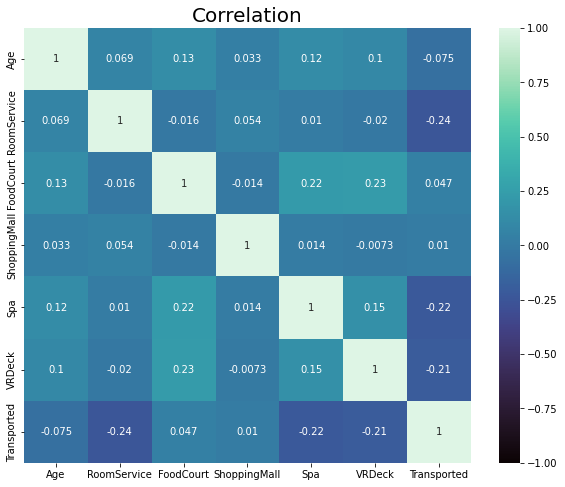

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(
    train_dataset.corr(),
    xticklabels=train_dataset.corr().columns,
    yticklabels=train_dataset.corr().columns,
    cmap='mako', 
    vmin=-1, vmax=1,
    annot=True, 
    center=0
                 )

plt.title('Correlation', fontsize=20)

plt.show()

## Histograms

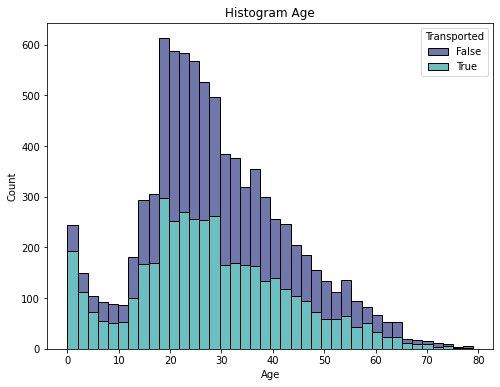

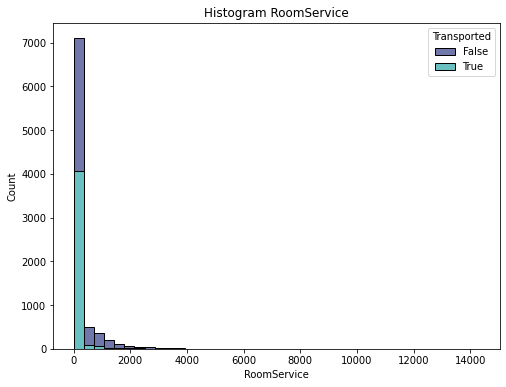

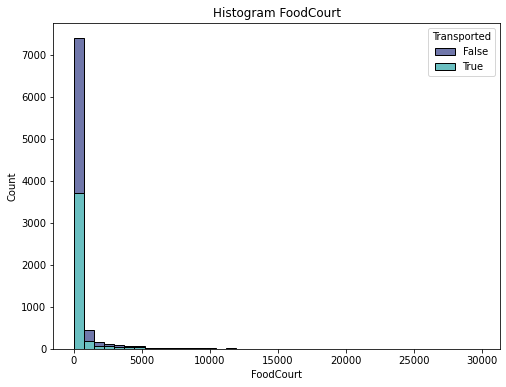

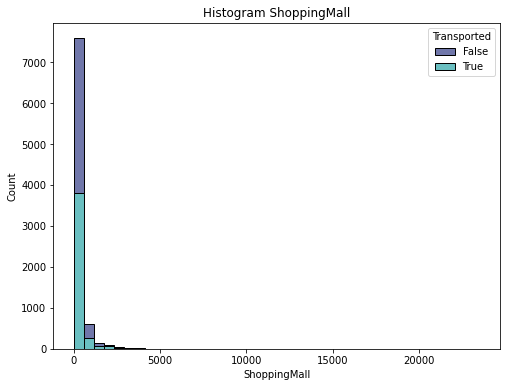

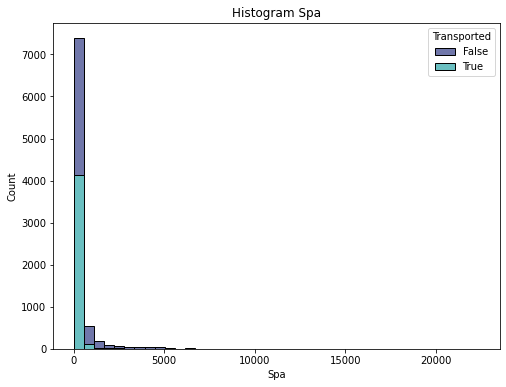

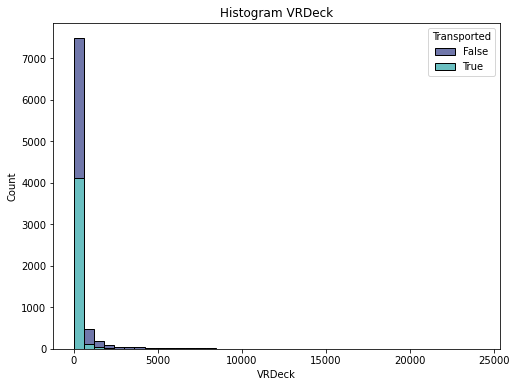

In [ ]:
column_names_list = ('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',	'VRDeck')
for i in column_names_list:
  plot_histogram(data = train_dataset, x = i)

## Countplot 'transported'
The target value 'transported' is well balanced.

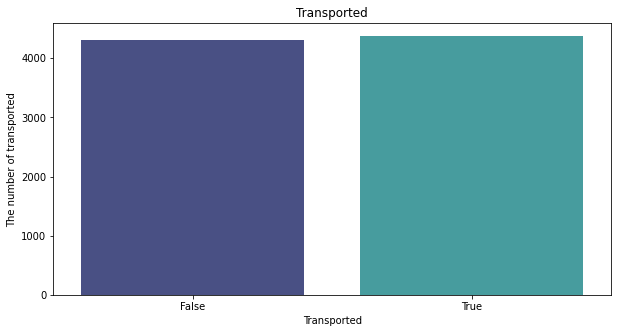

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = train_dataset, x ='Transported', palette = 'mako')
plt.title('Transported')
plt.ylabel('The number of transported')
plt.show()

# Missing values

In [ ]:
train_dataset.isnull().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

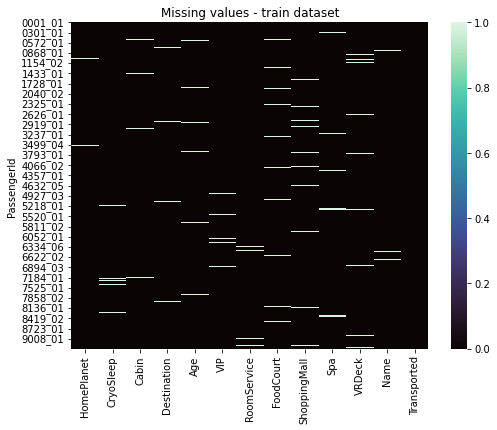

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(train_dataset.isnull(), cmap = 'mako')
plt.title('Missing values - train dataset')
plt.show()

In [ ]:
test_dataset.isnull().sum().sort_values(ascending = False)

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

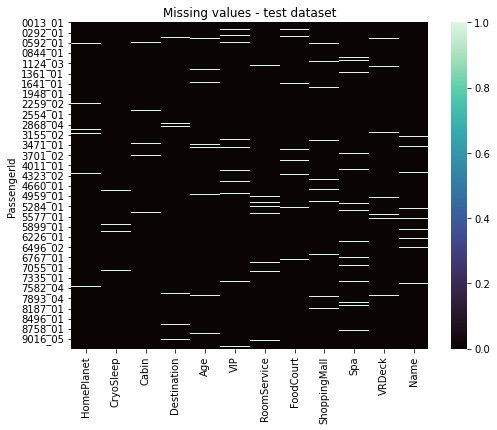

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(test_dataset.isnull(), cmap = 'mako')
plt.title('Missing values - test dataset')
plt.show()

## 'CryoSleep'

*   CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
*   217 missing values in train dataset
*   93 missing values in test dataset

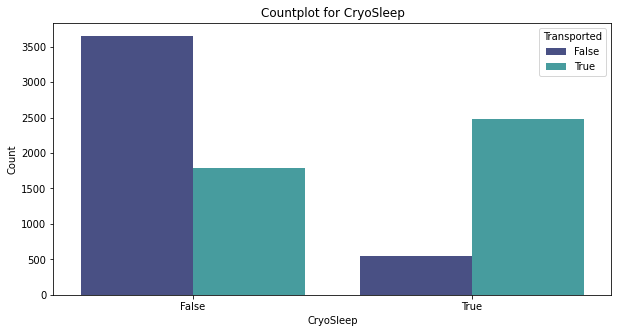

In [ ]:
countplot_categorical(data = train_dataset, x ='CryoSleep', hue = 'Transported', palette = 'mako')

In [ ]:
train_dataset['CryoSleep'].unique()

array([False, True, nan], dtype=object)

1.   If someone could spend money on Shopping or FoodCourt or Spa or Room Service or VRDeck then CryoSleep must be False.
2.   Fill in the remaining missing values ​​randomly (True/False)



In [ ]:
train_dataset.loc[(train_dataset['ShoppingMall'] > 0) | 
                  (train_dataset['FoodCourt'] > 0) | 
                  (train_dataset['Spa'] > 0) |
                  (train_dataset['VRDeck'] > 0) |
                  (train_dataset['RoomService'] > 0) & 
                  (train_dataset['CryoSleep'].isna()), 'CryoSleep']= False

train_dataset['CryoSleep'].fillna(random.choice([True, False]), inplace=True)

In [ ]:
test_dataset.loc[(test_dataset['ShoppingMall'] > 0) | 
                  (test_dataset['FoodCourt'] > 0) | 
                  (test_dataset['Spa'] > 0) |
                 (test_dataset['VRDeck'] > 0) |
                  (test_dataset['RoomService'] > 0) & 
                  (test_dataset['CryoSleep'].isna()), 'CryoSleep']= False

test_dataset['CryoSleep'].fillna(random.choice([True, False]), inplace=True)

## 'ShoppingMall', 'FoodCourt', 'Spa', 'RoomService', 'VRDeck'

Train dataset:
*   ShoppingMall 208 missing values 
*   FoodCourt 183 missing valuses
*   Spa 183 missing values
*   RoomService 181 missing values
*   VRDeck 188 missing values

Test dataset:
*   ShoppingMall 98 missing values 
*   FoodCourt 106 missing valuses
*   Spa 101 missing values
*   RoomService 82 missing values
*   VRDeck 80 missing values



1.   If 'CryoSleep' is True (the passenger elected to be put into suspended animation for the duration of the voyage) then the passenger could not spend money on ship. So fill in with 0.
2.   Fill in the remaining missing values mean

In [ ]:
service_columns = ['ShoppingMall', 'FoodCourt', 'Spa', 'RoomService', 'VRDeck']

for i in service_columns:
  missing_values_service_column(dataset = train_dataset, column = i)

for i in service_columns:
  missing_values_service_column(dataset = test_dataset, column = i)

## 'Age'


*   Age - The age of the passenger.
*   179 missing values in train dataset
*   91 missing values in test dataset

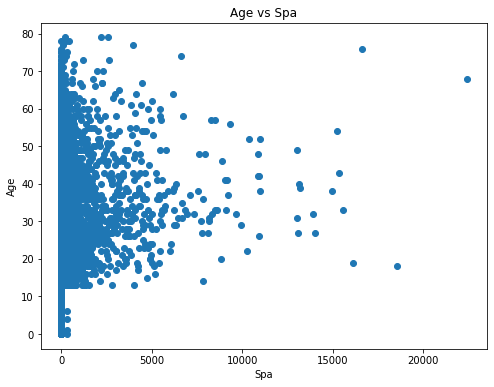

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(train_dataset['Spa'], train_dataset['Age'])
plt.title('Age vs Spa')
plt.xlabel('Spa')
plt.ylabel('Age')
plt.show()

1.   If someone spent money in Spa, they are more likely to be older than 10 years old.
2.   Fill in the remaining missing values ​​randomly (from 0 to max age)



In [ ]:
train_dataset.loc[(train_dataset['Spa'] > 0)
                  & (train_dataset['Age'].isna()), 'Age']= random.randint(10, train_dataset['Age'].max()+1)
                  
train_dataset['Age'].fillna(random.randint(0, train_dataset['Age'].max()+1), inplace=True)

In [ ]:
test_dataset.loc[(test_dataset['Spa'] > 0)
                  & (test_dataset['Age'].isna()), 'Age']= random.randint(10, train_dataset['Age'].max()+1)
                  
test_dataset['Age'].fillna(random.randint(0, test_dataset['Age'].max()+1), inplace=True)

## 'VIP'
*   VIP -  Whether the passenger has paid for special VIP service during the voyage.
*   203 missing values in train dataset
*   93 missing values in test dataset

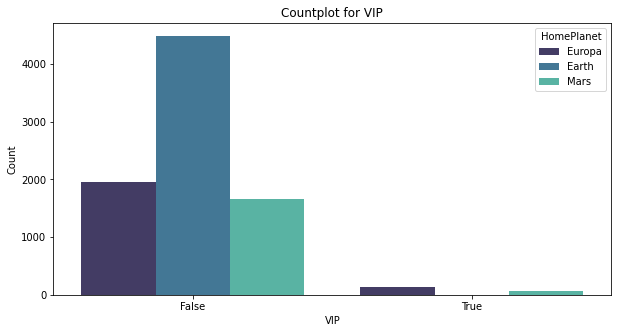

In [ ]:
countplot_categorical(data = train_dataset, x ='VIP', hue = 'HomePlanet', palette = 'mako')

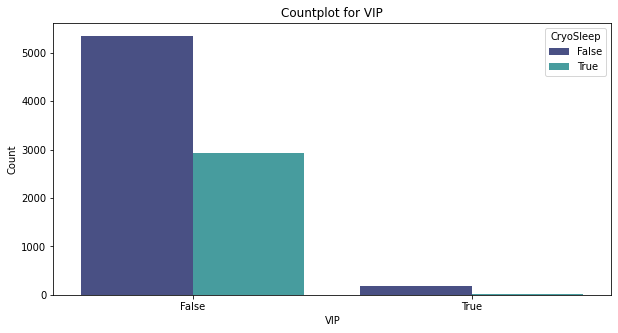

In [ ]:
countplot_categorical(data = train_dataset, x ='VIP', hue = 'CryoSleep', palette = 'mako')

1.   If someones HomePlanet is Europa or Mars or CryoSleep is False than VIP is likely True.
2.   Fill in the remaining missing values ​​randomly (True/False)

In [ ]:
train_dataset.loc[(train_dataset['HomePlanet'] != 'Earth') |
                  (train_dataset['CryoSleep'] == False)
                  & (train_dataset['VIP'].isna()), 'VIP']= True
                  
train_dataset['VIP'].fillna(random.choice([True, False]), inplace=True)

In [ ]:
test_dataset.loc[(test_dataset['HomePlanet'] != 'Earth') |
                  (test_dataset['CryoSleep'] == False)
                  & (test_dataset['VIP'].isna()), 'VIP']= True
                  
test_dataset['VIP'].fillna(random.choice([True, False]), inplace=True)

## 'HomePlanet'
*   HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
*   201 missing values in train dataset
*   87 missing values in test dataset






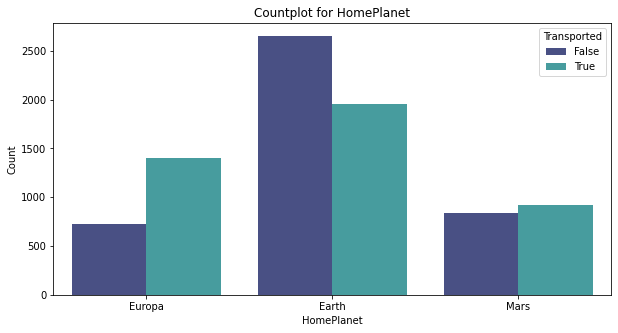

In [ ]:
countplot_categorical(data = train_dataset, x ='HomePlanet', hue = 'Transported', palette = 'mako')

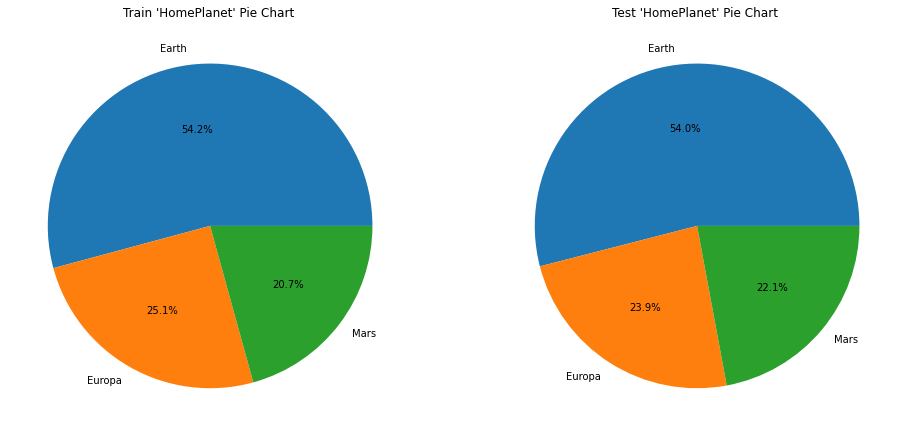

In [ ]:
counts_train = train_dataset['HomePlanet'].value_counts()
counts_test = test_dataset['HomePlanet'].value_counts()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].pie(counts_train, labels=counts_train.index, autopct='%1.1f%%')
ax[0].set_title("Train 'HomePlanet' Pie Chart ")

ax[1].pie(counts_test, labels=counts_test.index, autopct='%1.1f%%')
ax[1].set_title("Test 'HomePlanet' Pie Chart ")

plt.show()

1.   Fill the missing values randomly but with proportions: 0.54 Earth, 0.25 Europa, 0.21 Mars



In [ ]:
train_dataset['HomePlanet'].fillna(random.choice(['Earth', 'Europa', 'Mars'], p= [0.54, 0.25, 0.21]), inplace=True)
test_dataset['HomePlanet'].fillna(random.choice(['Earth', 'Europa', 'Mars'], p= [0.54, 0.25, 0.21]), inplace=True)

## 'Cabin'

*   Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
*   199 missing values in train dataset
*   100 missing values in test dataset

In [ ]:
# extracting cabin-deck, cabin-side

train_dataset['cabin-deck'] = train_dataset['Cabin'].str.get(0)
train_dataset['cabin-side'] = train_dataset['Cabin'].str.get(-1)

test_dataset['cabin-deck'] = test_dataset['Cabin'].str.get(0)
test_dataset['cabin-side'] = test_dataset['Cabin'].str.get(-1)

train_dataset.head(3)

HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                          
0001_01         Europa      False  B/0/P  TRAPPIST-1e  39.0   True   
0002_01          Earth      False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa      False  A/0/S  TRAPPIST-1e  58.0   True   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   

                        Name  Transported cabin-deck cabin-side  
PassengerId                                                      
0001_01      Maham Ofracculy        False          B          P  
0002_01         Juanna Vines         True          F          S  
0003_01        Altark Susent        False          A          S

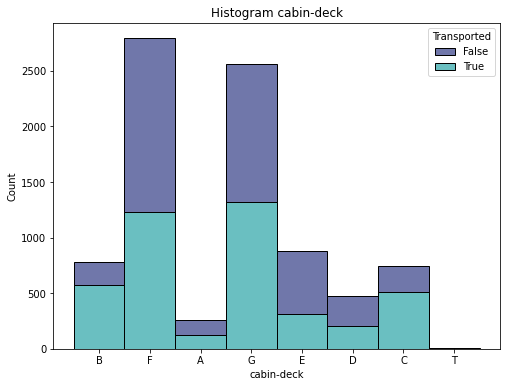

In [ ]:
plot_histogram(data = train_dataset, x = 'cabin-deck')

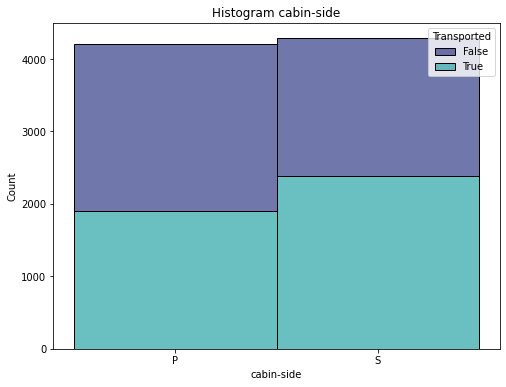

In [ ]:
plot_histogram(data = train_dataset, x = 'cabin-side')

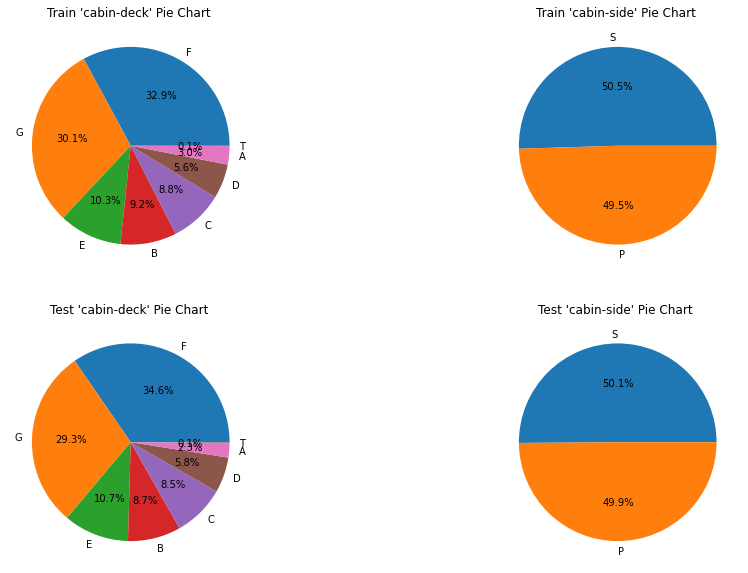

In [ ]:
counts_side_train = train_dataset['cabin-side'].value_counts()
counts_deck_train= train_dataset['cabin-deck'].value_counts()
counts_side_test = test_dataset['cabin-side'].value_counts()
counts_deck_test = test_dataset['cabin-deck'].value_counts()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

ax[0, 0].pie(counts_deck_train, 
          labels=counts_deck_train.index, autopct='%1.1f%%')
ax[0, 0].set_title("Train 'cabin-deck' Pie Chart ")

ax[0, 1].pie(counts_side_train, 
          labels=counts_side_train.index, autopct='%1.1f%%')
ax[0, 1].set_title("Train 'cabin-side' Pie Chart ")

ax[1, 0].pie(counts_deck_test, 
          labels=counts_deck_test.index, autopct='%1.1f%%')
ax[1, 0].set_title("Test 'cabin-deck' Pie Chart ")

ax[1, 1].pie(counts_side_test, 
          labels=counts_side_test.index, autopct='%1.1f%%')
ax[1, 1].set_title("Test 'cabin-side' Pie Chart ")

plt.show()

1.   Fill the missing values in 'cabin-deck' randomly but with proportions: 0.33, 0.3, 0.1, 0.92, 0.88, 0.56, 0.03, 0.001 for cabin: F, G, E, B, C, D, A, T
2.   Fill the missing values in 'cabin-side' randomly with proportions: 0.5, 0.5




In [ ]:
train_dataset['cabin-deck'].fillna(
    random.choice(['F', 'G', 'E', 'B', 'C', 'D', 'A', 'T'], 
                  p= [0.33, 0.3, 0.103, 0.092, 0.088, 0.056, 0.03, 0.001]), 
                  inplace=True)

test_dataset['cabin-deck'].fillna(
    random.choice(['F', 'G', 'E', 'B', 'C', 'D', 'A', 'T'], 
                  p= [0.33, 0.3, 0.103, 0.092, 0.088, 0.056, 0.03, 0.001]), 
                  inplace=True)

In [ ]:
train_dataset['cabin-side'].fillna(
    random.choice(['P', 'S'], 
                  p= [0.5, 0.5]), 
                  inplace=True)

test_dataset['cabin-side'].fillna(
    random.choice(['P', 'S'], 
                  p= [0.5, 0.5]), 
                  inplace=True)

## 'Destination'

*   Destination - The planet the passenger will be debarking to.
*   182 missing values in train dataset
*   92 missing values in test dataset

In [ ]:
train_dataset['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

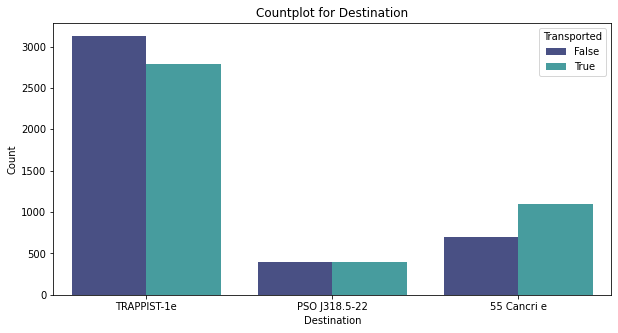

In [ ]:
countplot_categorical(data = train_dataset, x ='Destination', hue = 'Transported', palette = 'mako')

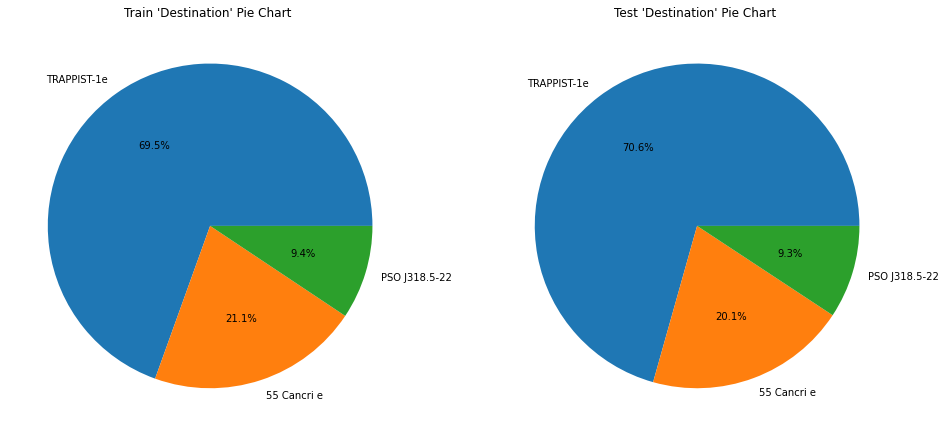

In [ ]:
counts_train = train_dataset['Destination'].value_counts()
counts_test = test_dataset['Destination'].value_counts()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].pie(counts_train, labels=counts_train.index, autopct='%1.1f%%')
ax[0].set_title("Train 'Destination' Pie Chart ")

ax[1].pie(counts_test, labels=counts_test.index, autopct='%1.1f%%')
ax[1].set_title("Test 'Destination' Pie Chart ")

plt.show()

1.   Fill the missing values in 'Destination' randomly but with proportions: 0.7, 0.21, 0.09 for: 'TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'

In [ ]:
train_dataset['Destination'].fillna(
    random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], 
                  p= [0.7, 0.21, 0.09]), 
                  inplace=True)

test_dataset['Destination'].fillna(
    random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], 
                  p= [0.7, 0.21, 0.09]), 
                  inplace=True)

## Summary
Missing data was individually adjusted depending on the column. The columns 'Name' and 'Cabin' will not be taken into the model, so they will be left with missing values.

In [ ]:
train_dataset.isnull().sum().sort_values(ascending = False)

Name            200
Cabin           199
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
cabin-deck        0
cabin-side        0
dtype: int64

In [ ]:
test_dataset.isnull().sum().sort_values(ascending = False)

Cabin           100
Name             94
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
cabin-deck        0
cabin-side        0
dtype: int64

# Categorical values


*   Object type: 'HomePlanet', 'cabin-deck', 'cabin-side', 'Destination'
*   Bool type: 'CryoSleep' and 'VIP'


1.   Ordinal Encoding for 'cabin-side', 'CryoSleep' and 'VIP'
2.   One-Hot Encoding for 'HomePlanet', 'cabin-deck', 'Destination'




In [ ]:
columns_oridinal_encoding = ['cabin-side', 'CryoSleep', 'VIP']
columns_ohe = ['HomePlanet', 'cabin-deck', 'Destination']

ordinal_encoder = OrdinalEncoder()
train_dataset[columns_oridinal_encoding] = ordinal_encoder.fit_transform(train_dataset[columns_oridinal_encoding])
test_dataset[columns_oridinal_encoding] = ordinal_encoder.fit_transform(test_dataset[columns_oridinal_encoding])

train_dataset = pd.get_dummies(train_dataset, columns = columns_ohe, drop_first = True)
test_dataset = pd.get_dummies(test_dataset, columns = columns_ohe, drop_first = True)

In [ ]:
train_dataset.head(3)

CryoSleep  Cabin   Age  VIP  RoomService  FoodCourt  \
PassengerId                                                        
0001_01            0.0  B/0/P  39.0  1.0          0.0        0.0   
0002_01            0.0  F/0/S  24.0  0.0        109.0        9.0   
0003_01            0.0  A/0/S  58.0  1.0         43.0     3576.0   

             ShoppingMall     Spa  VRDeck             Name  ...  \
PassengerId                                                 ...   
0001_01               0.0     0.0     0.0  Maham Ofracculy  ...   
0002_01              25.0   549.0    44.0     Juanna Vines  ...   
0003_01               0.0  6715.0    49.0    Altark Susent  ...   

             HomePlanet_Mars  cabin-deck_B  cabin-deck_C  cabin-deck_D  \
PassengerId                                                              
0001_01                    0             1             0             0   
0002_01                    0             0             0             0   
0003_01                    0             0             0             0   

             cabin-deck_E  cabin-deck_F  cabin-deck_G  cabin-deck_T  \
PassengerId                                                           
0001_01                 0             0             0             0   
0002_01                 0             1             0             0   
0003_01                 0             0             0             0   

             Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
PassengerId                                                      
0001_01                              0                        1  
0002_01                              0                        1  
0003_01                              0                        1  

[3 rows x 23 columns]

In [ ]:
train_dataset.columns

Index(['CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'cabin-side',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'cabin-deck_B', 'cabin-deck_C',
       'cabin-deck_D', 'cabin-deck_E', 'cabin-deck_F', 'cabin-deck_G',
       'cabin-deck_T', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

# Divide dataset into train, validation and test subset

In [ ]:
X = train_dataset[['CryoSleep', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'cabin-side', 'HomePlanet_Europa', 'HomePlanet_Mars', 'cabin-deck_B',
       'cabin-deck_C', 'cabin-deck_D', 'cabin-deck_E', 'cabin-deck_F',
       'cabin-deck_G', 'cabin-deck_T', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e']]
y = train_dataset['Transported']

# Split data into train, validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# test set
X_test = test_dataset[['CryoSleep', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'cabin-side', 'HomePlanet_Europa', 'HomePlanet_Mars', 'cabin-deck_B',
       'cabin-deck_C', 'cabin-deck_D', 'cabin-deck_E', 'cabin-deck_F',
       'cabin-deck_G', 'cabin-deck_T', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e']]

# ML algorithms to classify passengers

## Random Forest, XGBoost, LightGBM

In [ ]:
models = [RandomForestClassifier(random_state=42), 
          XGBClassifier(), 
          LGBMClassifier(), 
          ]

for model in models:
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  print_result(calculate_metrics(y_val, y_val_pred), f'{model}')

Result for RandomForestClassifier(random_state=42) 

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F-Score: 0.77
Total: 1739
Mislabeled: 393 

Result for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 1739
Mislabeled: 368 

Result

## CatBoost

In [ ]:
# Tu działa funkcja do liczenia metryk, ale uzyty jest Pool

model = CatBoostClassifier()
model.fit(X_train, y_train,
     eval_set=(X_val, y_val),
     verbose=False, plot=False)
test_pool = Pool(X_val, y_val)   # Pool
y_val_pred = model.predict(test_pool)
y_val_pred = y_val_pred.astype(y_val.dtype)  #zmiana typu
print_result(calculate_metrics(y_val, y_val_pred), f'CatBoostClassifier')

Result for CatBoostClassifier 

Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-Score: 0.34
Total: 1739
Mislabeled: 861 



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### with missing values and categorical values

In [12]:
train_df = train_dataset.copy()
test_df = test_dataset.copy()

In [13]:
# prepare dataset
train_df = train_df.drop(['Cabin', 'Name'], axis = 1)
test_df = test_df.drop(['Cabin', 'Name'], axis = 1)
# categorical columns
cat_features = ["HomePlanet", "Destination"]

train_df['HomePlanet'].fillna(random.choice(['Earth', 'Europa', 'Mars'], p= [0.54, 0.25, 0.21]), inplace=True)
test_df['HomePlanet'].fillna(random.choice(['Earth', 'Europa', 'Mars'], p= [0.54, 0.25, 0.21]), inplace=True)

train_df['Destination'].fillna(
    random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], 
                  p= [0.7, 0.21, 0.09]), 
                  inplace=True)

test_df['Destination'].fillna(
    random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], 
                  p= [0.7, 0.21, 0.09]), 
                  inplace=True)

In [14]:
X = train_df.drop('Transported', axis = 1)
y = train_df[['Transported']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df

In [19]:
model  = CatBoostClassifier(iterations = 500,
                            learning_rate = 0.1,
                            depth = 5,
                            one_hot_max_size = 3,
                            cat_features = cat_features,
                            counter_calc_method = 'Full',
                            border_count = 10,
                            verbose = 50,
                            random_seed = 42
                            )

model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.astype(y_val['Transported'])   # Jak to się zakomentuje to będzie błąd Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']
accuracy_score(y_val, y_val_pred)

0:	learn: 0.6561398	total: 7.19ms	remaining: 3.59s
50:	learn: 0.4290033	total: 282ms	remaining: 2.48s
100:	learn: 0.4103437	total: 465ms	remaining: 1.83s
150:	learn: 0.3950983	total: 617ms	remaining: 1.43s
200:	learn: 0.3823929	total: 839ms	remaining: 1.25s
250:	learn: 0.3705413	total: 1.06s	remaining: 1.05s
300:	learn: 0.3606977	total: 1.2s	remaining: 795ms
350:	learn: 0.3520808	total: 1.36s	remaining: 580ms
400:	learn: 0.3443718	total: 1.5s	remaining: 370ms
450:	learn: 0.3374987	total: 1.68s	remaining: 182ms
499:	learn: 0.3318003	total: 1.85s	remaining: 0us


0.5048878665899943

In [16]:
print(precision_score(y_val, y_val_pred))
print(recall_score(y_val, y_val_pred))
print(f1_score(y_val, y_val_pred))

0.5048878665899943
1.0
0.6709973251815056


In [17]:
# ! ale wtedy nie działa napisana funkcja do liczenia matryk:
print_result(calculate_metrics(y_val, y_val_pred), f'CatBoostClassifier')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

# Optuna

## Random Forest

In [ ]:
def objective(trial):
    # Define the hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the RandomForestClassifier with the hyperparameters to be optimized
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, 
        max_features=max_features, 
        random_state=42)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Calculate the accuracy on the validation set
    accuracy = clf.score(X_val, y_val)

    # Return the accuracy as the objective value
    return accuracy


In [ ]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
# Print the best hyperparameters and the corresponding accuracy
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'n_estimators': 28, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}
Best accuracy: 0.7981598619896493


In [ ]:
model = RandomForestClassifier(n_estimators= 28, max_depth = 17, min_samples_split = 8, min_samples_leaf = 7, max_features = 'sqrt')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print_result(calculate_metrics(y_val, y_val_pred), 'RandomForestClassifier')

Result for RandomForestClassifier 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 1739
Mislabeled: 366 



## XGBoost

In [ ]:
def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.1, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1.0, 0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),

    }

    # Create the XGBClassifier with the hyperparameters to be optimized
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'max_depth': 4, 'eta': 0.07288727263058394, 'gamma': 7.664192213545383e-06, 'grow_policy': 'lossguide', 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 2, 'n_estimators': 573}
Best accuracy: 0.7958596894767107


In [ ]:
model_xg = XGBClassifier(max_depth = 4, 
                      eta = 0.07288727263058394, 
                      gamma = 7.664192213545383e-06, 
                      grow_policy = 'lossguide', 
                      subsample = 0.6, 
                      colsample_bytree = 0.6, 
                      min_child_weight = 2, 
                      n_estimators = 573)
model_xg.fit(X_train, y_train)
y_val_pred = model_xg.predict(X_val)
print_result(calculate_metrics(y_val, y_val_pred), 'XGBClassifier')

Result for XGBClassifier 

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F-Score: 0.8
Total: 1739
Mislabeled: 355 



## LightGBM

In [ ]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42
    }

    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    return accuracy


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'lambda_l1': 3.417199593159779, 'lambda_l2': 0.017340606461167682, 'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.016682548296829414, 'feature_fraction': 0.5126266483695845, 'bagging_fraction': 0.4866852303282229, 'bagging_freq': 5, 'min_child_samples': 95, 'n_estimators': 618}
Best accuracy: 0.7952846463484762


In [ ]:
model = LGBMClassifier(lambda_l1 = 3.417199593159779, 
                       lambda_l2 = 0.017340606461167682, 
                       num_leaves = 36, 
                       max_depth = 6, 
                       learning_rate = 0.016682548296829414, 
                       feature_fraction = 0.5126266483695845, 
                       bagging_fraction = 0.4866852303282229, 
                       bagging_freq = 5, 
                       min_child_samples = 95, 
                       n_estimators = 618)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print_result(calculate_metrics(y_val, y_val_pred), 'LGBMClassifier')

[LightGBM] [Warning] lambda_l1 is set=3.417199593159779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.417199593159779
[LightGBM] [Warning] feature_fraction is set=0.5126266483695845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126266483695845
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.017340606461167682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017340606461167682
[LightGBM] [Warning] bagging_fraction is set=0.4866852303282229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4866852303282229
Result for LGBMClassifier 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 1739
Mislabeled: 360 



## CatBoost

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.1, 10),
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, verbose=False)

    test_pool = Pool(X_val, y_val)
    y_pred = model.predict(test_pool)
    y_pred = y_pred.astype(y_val.dtype)
    
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'iterations': 610, 'learning_rate': 0.02935312297292448, 'depth': 10, 'l2_leaf_reg': 0.4095699607600287, 'bagging_temperature': 0.042090158760203486, 'random_strength': 0.893371179302546}
Best accuracy: 0.5048878665899943


In [ ]:
model = CatBoostClassifier(iterations = 610, 
                           learning_rate = 0.02935312297292448, 
                           depth = 10, 
                           l2_leaf_reg = 0.4095699607600287, 
                           bagging_temperature = 0.042090158760203486, 
                           random_strength = 0.893371179302546)
model.fit(X_train, y_train,
     eval_set=(X_val, y_val),
     verbose=False, plot=False)
test_pool = Pool(X_val, y_val)
y_val_pred = model.predict(test_pool)
y_val_pred = y_val_pred.astype(y_val.dtype)
print_result(calculate_metrics(y_val, y_val_pred), f'CatBoostClassifier')

Result for CatBoostClassifier 

Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F-Score: 0.34
Total: 1739
Mislabeled: 861 



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Subbmition

In [ ]:
y_test_pred = model_xg.predict(X_test)
y_test_pred = np.array(list(map(lambda x: True if x == 1 else False, y_test_pred)))
subm_1 = X_test.index
result = pd.DataFrame({'PassengerId': subm_1, 'Transported': y_test_pred})
result.to_csv('./submission.csv', index = False)

# PyTorch

## 1. Implement logistic regression model

In [ ]:
# test split 
X_train, X_val, y_train, y_val = train_test_split(train_dataset.drop(['Cabin', 'Transported', 'Name'],  axis=1), 
                                                  train_dataset['Transported'], test_size=0.2, random_state=42)


In [ ]:
#standard scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
#converting to pytorch tensor

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_train = y_train.reshape(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_val = y_val.reshape(-1, 1)

In [ ]:
X_train.shape

torch.Size([6954, 20])

In [ ]:
y_train.shape

torch.Size([6954, 1])

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(20, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out


In [ ]:
# Binary Cross Entropy Loss function

model = LogisticRegression(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.4796
Epoch [200/1000], Loss: 0.4591
Epoch [300/1000], Loss: 0.4504
Epoch [400/1000], Loss: 0.4453
Epoch [500/1000], Loss: 0.4418
Epoch [600/1000], Loss: 0.4394
Epoch [700/1000], Loss: 0.4376
Epoch [800/1000], Loss: 0.4362
Epoch [900/1000], Loss: 0.4351
Epoch [1000/1000], Loss: 0.4343


In [ ]:
with torch.no_grad():
    outputs = model(X_val)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_val).sum() / y_val.shape[0]
    print(f"Accuracy on test set: {accuracy.item():.4f}")

Accuracy on test set: 0.7821


## 2. Use k-fold technique to entry dataset division

In [ ]:
train_df = train_dataset.copy()

In [ ]:
train_dataset_kfold = train_df.drop(['Cabin', 'Name'],  axis=1)
scaler = StandardScaler()
# train_dataset_kfold = scaler.fit_transform(train_dataset_kfold)
train_dataset_kfold = pd.DataFrame(StandardScaler().fit_transform(train_dataset_kfold), columns=train_dataset_kfold.columns, index=train_dataset_kfold.index)

In [ ]:
k = 5
dataset_size = len(train_dataset_kfold)
fold_size = dataset_size // k
folds = random_split(train_dataset_kfold, [fold_size] * (k - 1) + [dataset_size - fold_size * (k - 1)])

# iteracja po foldach
for i in range(k):
    # wybierz i-tą część jako zbiór testowy, a pozostałe części jako zbiór treningowy
    val_dataset = folds[i]
    train_datasets = [folds[j] for j in range(k) if j != i]
    train_dataset = ConcatDataset(train_datasets)

In [ ]:

# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(train_dataset_kfold.drop('Transported', axis=1).values).float()
        self.y = torch.from_numpy(train_dataset_kfold['Transported'].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

# Set up k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

# Train and evaluate model for each fold
for fold, (train_index, test_index) in enumerate(kf.split(train_dataset_kfold)):
    # Prepare data for fold
    train_data = train_dataset_kfold.loc[train_index].values
    test_data = train_dataset_kfold.loc[test_index].values

    train_dataset = CustomDataset(train_data)
    test_dataset = CustomDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    model = LogisticRegression(input_size=train_dataset.X.shape[1])

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    # Train model
    for epoch in range(10):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

    # Evaluate model
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            output = model(batch_X)
            predicted = (output > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y.view(-1, 1)).sum().item()

    accuracy = correct / total
    print(f'Fold {fold + 1}: accuracy = {accuracy:.4f}')

KeyError: ignored